# Amazon: 20 years of reviews

In [31]:
import pickle
import pandas as pd
import numpy as np
import fastparquet
%matplotlib inline

In [32]:
# directory where you have the parquet files. You need them to run any analysis.
# Download Parquets here: https://drive.google.com/open?id=1BkH7vfupcBaLs2gTYphff6z9Qvg-TcAq
# Extract parquet.tar.gz to the directory of you notebook or change the PARQUET_DIR
PARQUET_DIR = './parquet/'

In [ ]:
# IMPORTANT! Evaluate this cell once in order to rename parquet files for easy data processing.
# Sorry for the inconvenience. I will properly document the cleaning phase later.
import os
for index, row in reviews.iterrows():
    os.rename(PARQUET_DIR+row['parquet'], PARQUET_DIR+row['category']+'.parquet.gzip')

In [35]:
#US reviews by category
with open('category_reviews.pickle', 'rb') as file:
    category_reviews = pickle.load(file)

In [36]:
reviews = category_reviews[['category']]
reviews.head()

,category
0,Shoes
1,Mobile_Apps
2,Personal_Care_Appliances
3,Home_Improvement
4,Digital_Video_Download


In [5]:
def parquet_filename(category):
    return PARQUET_DIR + category + '.parquet.gzip'

def read_DataFrame(category):
    return pd.read_parquet(parquet_filename(category))

In [6]:
read_DataFrame('Books').head()

,customer_id,review_id,product_parent,product_category,star_rating,helpful_votes,total_votes,review_date
0,25933450,RJOVP071AVAJO,84656342,Books,5,0,0,2015-08-31
1,1801372,R1ORGBETCDW3AI,729938122,Books,5,0,0,2015-08-31
2,5782091,R7TNRFQAOUTX5,678139048,Books,5,0,0,2015-08-31
3,32715830,R2GANXKDIFZ6OI,712432151,Books,5,0,0,2015-08-31
4,14005703,R2NYB6C3R8LVN6,800572372,Books,5,2,2,2015-08-31


## Explore categories

Let's check what category has the most reviews.

In [33]:
def review_count(category):
    """
    Count all reviews
    """
    return read_DataFrame(category).shape[0]

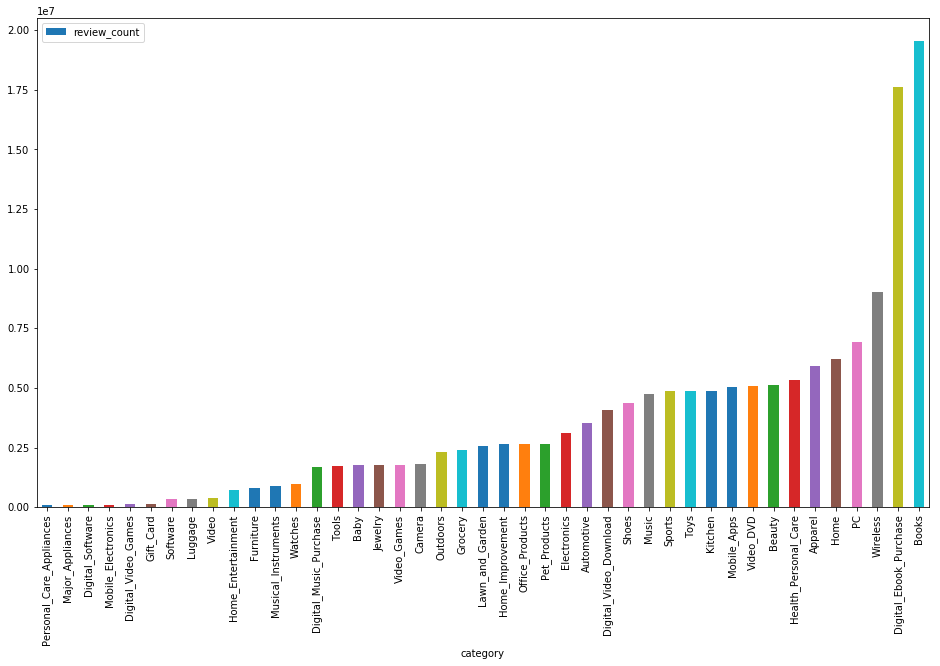

In [34]:
reviews['review_count'] = reviews['category'].apply(review_count)
reviews.sort_values("review_count").plot.bar(x='category', y='review_count', figsize=(16,9))

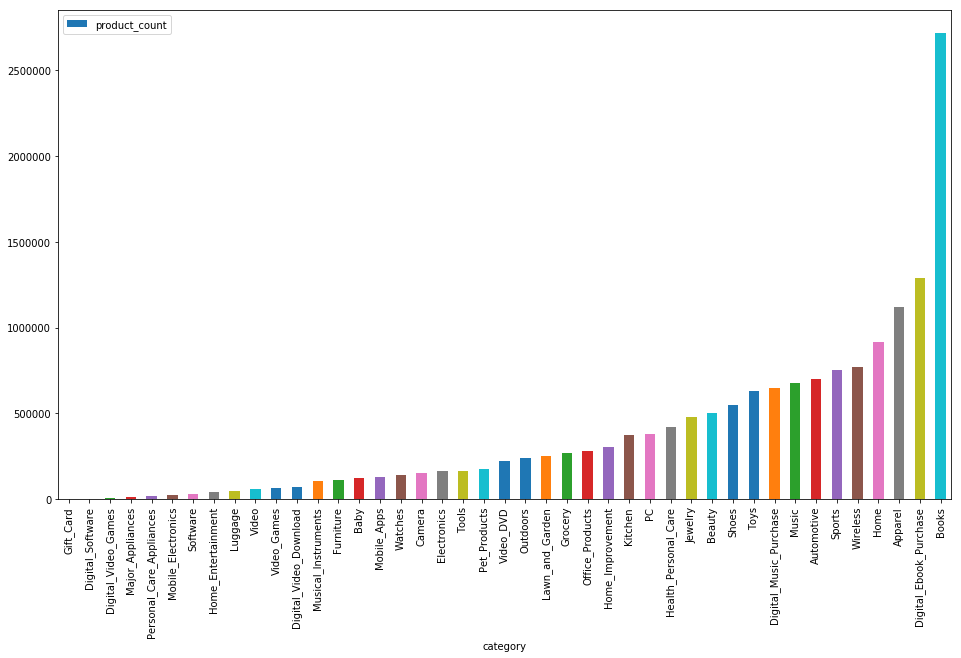

In [36]:
def product_count(category):
    """
    Count unique products
    """
    return read_DataFrame(category).product_parent.nunique()

reviews['product_count'] = reviews['category'].apply(product_count)
reviews.sort_values("product_count").plot.bar(x='category', y='product_count', figsize=(16,9))

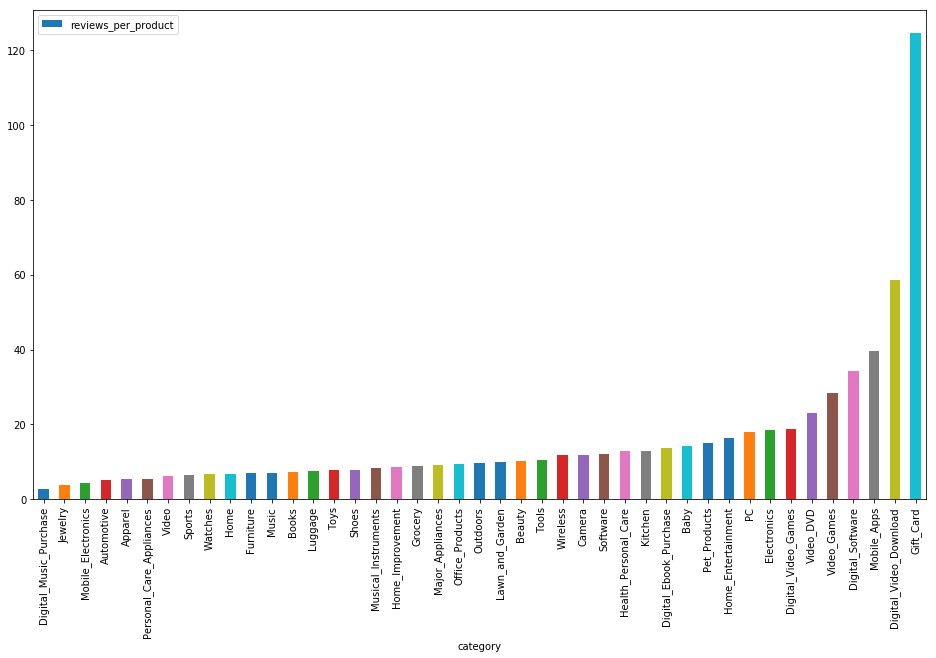

In [38]:
# How many reviews per product in average
reviews['reviews_per_product'] = reviews['review_count']/reviews['product_count']
reviews.sort_values('reviews_per_product').plot.bar(x='category', y='reviews_per_product', figsize=(16,9))

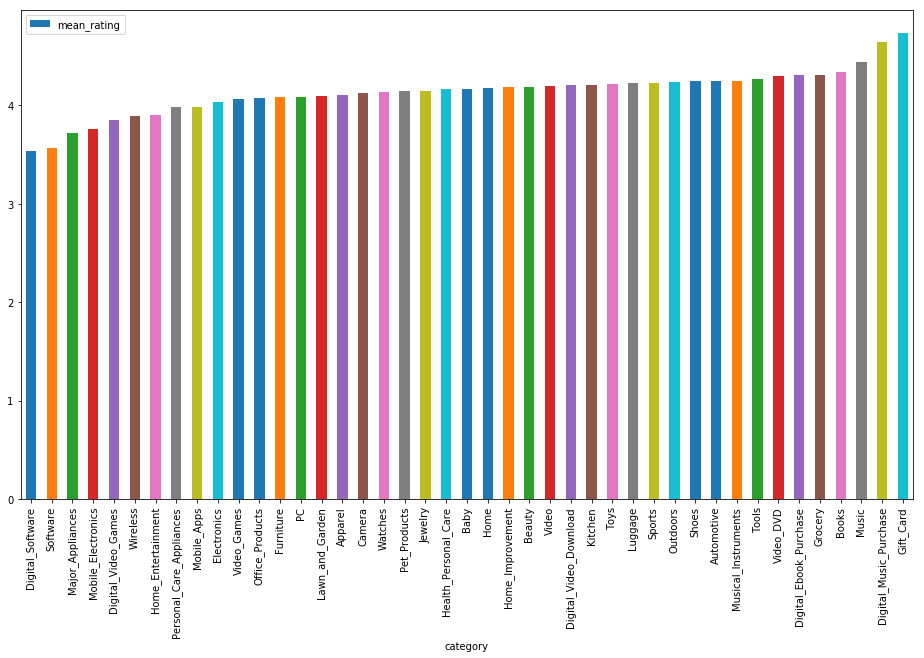

In [40]:
# Mean rating within a category

def mean_rating(category):
    return read_DataFrame(category).star_rating.mean()

reviews['mean_rating'] = reviews['category'].apply(mean_rating)
reviews.sort_values('mean_rating').plot.bar(x='category', y='mean_rating', figsize=(16,9))

At first sight, we can see that softwares are more subjected to contreverse regarding the ratings whereas music and books receive in general better grades.
Indeed, categories such as books may be biased in terms of reviews as the buyer is already interested in buying a book which is supposed to interest him. On the contrary, people buyin software or electronic devices may be more disappointed, hence handing out lower ratings.

*Hm, I am not convinced by this explanation. There are not many reviews and products in Software categories, maybe the stats are not reliable? - PJ*


This hypothese can help us in chosing a category to investigate review's reliability.

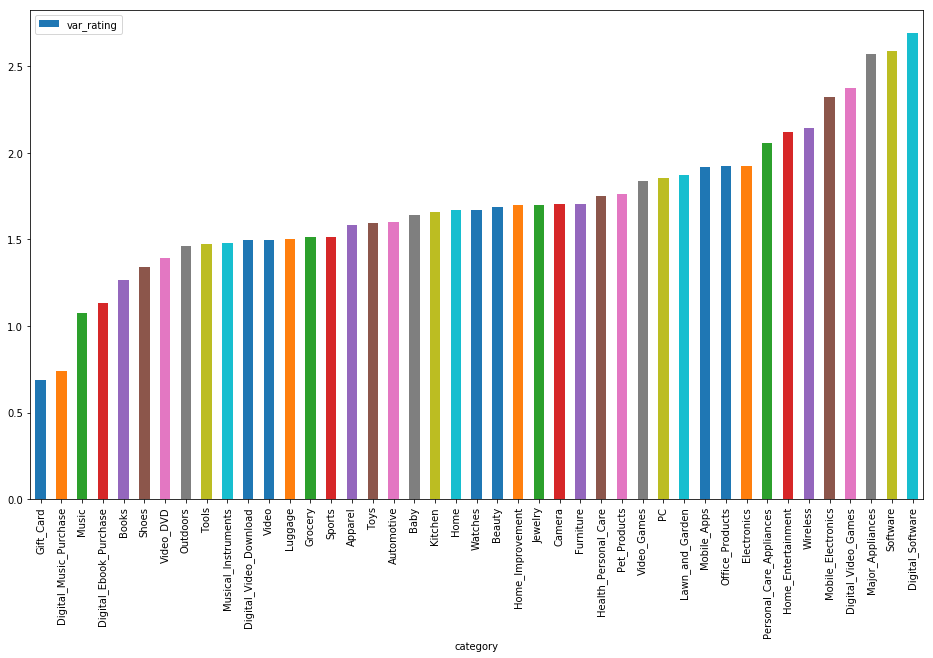

In [41]:
#Variance of raiting within category

def var_rating(category):
    return read_DataFrame(category).star_rating.var()

reviews['var_rating'] = reviews['category'].apply(var_rating)
reviews.sort_values('var_rating').plot.bar(x='category', y='var_rating', figsize=(16,9))

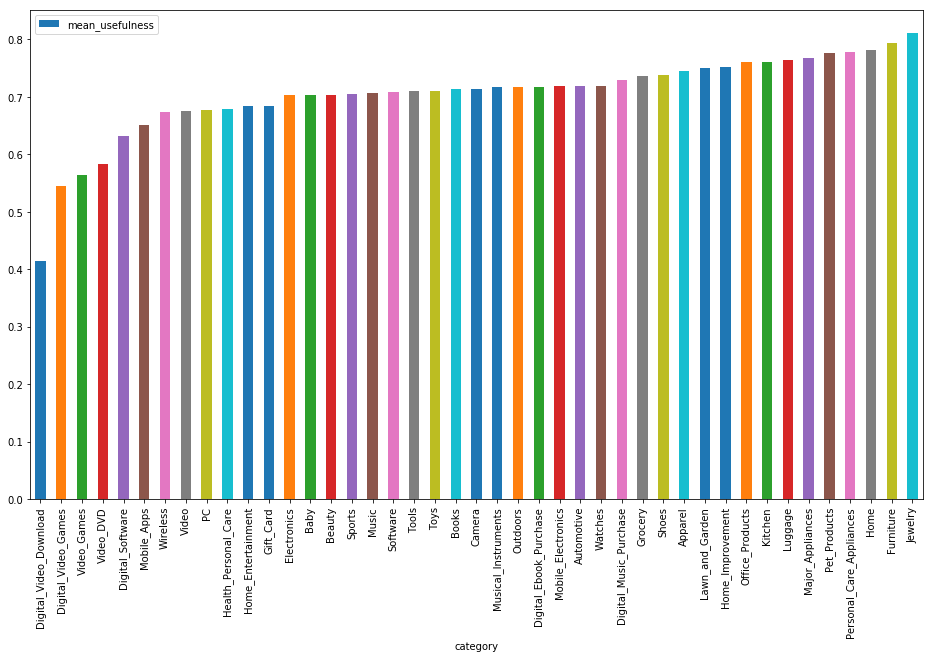

In [45]:
# Mean usefulness score of a category
def mean_usefulness(category):
    df = read_DataFrame(category)
    return np.mean(df.helpful_votes / df.total_votes)

reviews['mean_usefulness'] = reviews['category'].apply(mean_usefulness)
reviews.sort_values('mean_usefulness').plot.bar(x='category', y='mean_usefulness', figsize=(16,9))

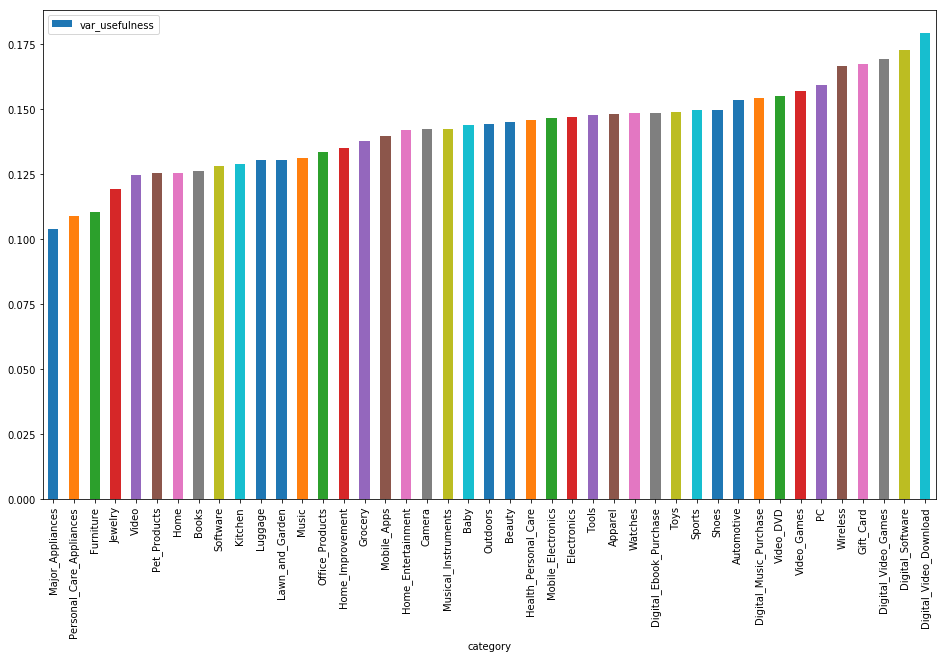

In [47]:
# Variance of usefulness within a category
def var_usefulness(category):
    df = read_DataFrame(category)
    return np.var(df.helpful_votes / df.total_votes)

reviews['var_usefulness'] = reviews['category'].apply(var_usefulness)
reviews.sort_values('var_usefulness').plot.bar(x='category', y='var_usefulness', figsize=(16,9))

In [48]:
reviews.head()

,category,review_count,product_count,reviews_per_product,mean_rating,var_rating,mean_usefulness,var_usefulness
0,Shoes,4366761,551635,7.916033,4.241256,1.339806,0.738165,0.149615
1,Mobile_Apps,5033305,127061,39.613296,3.981599,1.917181,0.651378,0.139600
2,Personal_Care_Appliances,85978,15919,5.400967,3.977401,2.053911,0.777162,0.108649
3,Home_Improvement,2634428,303796,8.671701,4.182400,1.696582,0.751364,0.134908
4,Digital_Video_Download,4056597,69281,58.552807,4.201211,1.496933,0.414669,0.179085


## Temporal analysis

In [18]:
chosen_categories = ['Books', 'Wireless', 'PC', 'Home', 'Toys', 'Mobile_Apps']

In [22]:
def count_reviews_by_year(category, df):
    df_read = read_DataFrame(category)
    df[category] = df_read.groupby(pd.DatetimeIndex(df_read['review_date']).year).size()

In [23]:
def temporal_analysis(chosen_categories, method):
    df = pd.DataFrame()
    for category in chosen_categories:
        method(category, df)
    return df

In [24]:
df_years = temporal_analysis(chosen_categories, count_reviews_by_year)
df_years

,Books,Wireless,PC,Home,Toys,Mobile_Apps
review_date,,,,,,
1995,198,NaN,NaN,NaN,NaN,NaN
1996,4670,NaN,NaN,NaN,NaN,NaN
1997,36610,NaN,NaN,NaN,1.0,NaN
1998,120851,2.0,NaN,5.0,40.0,NaN
1999,244559,102.0,384.0,7.0,1974.0,NaN
2000,540476,581.0,3596.0,165.0,3278.0,NaN
2001,444904,1633.0,6588.0,738.0,6184.0,NaN
2002,426895,1413.0,10125.0,2075.0,12676.0,NaN
2003,440007,2562.0,13630.0,5800.0,19165.0,NaN


In [29]:
def plot_temporal_evolution(chosen_categories, df):
    df.plot(y=chosen_categories, figsize=(16,10))

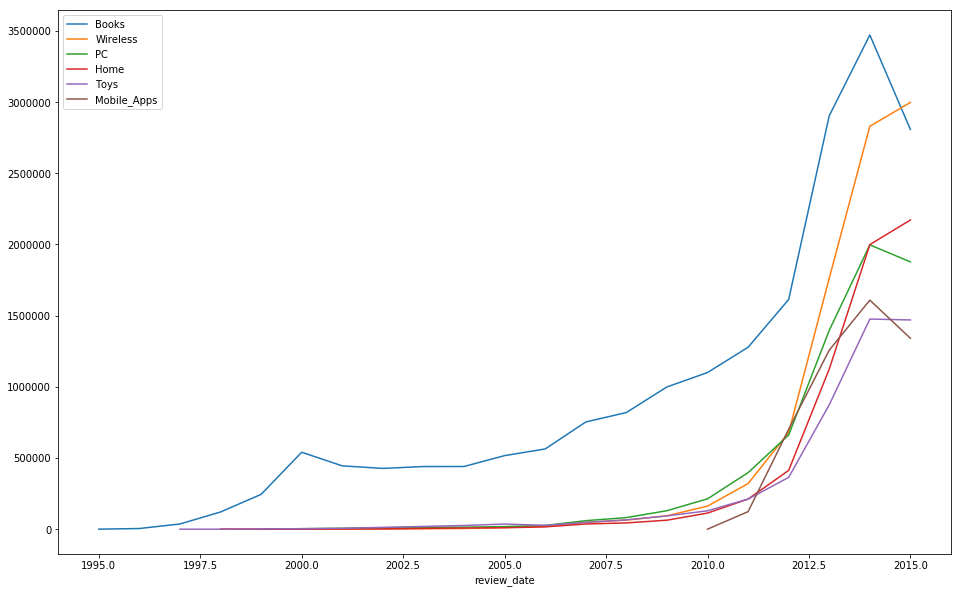

In [30]:
plot_temporal_evolution(chosen_categories, df_years)

In [ ]:
def 